In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.pyplot import figure
import pandas as pd
import torch
import numpy as np

In [2]:
cuda=True
device = torch.device("cuda" if cuda else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
#Download train and test datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
# Size of training and testing data
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [6]:
# Create DataLoaders 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=64, shuffle=False, drop_last=True)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_d=100 ):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_d, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)

    
    def forward(self, x):
        #x = x.view(-1, 784)
        x=F.leaky_relu(self.fc1(x),negative_slope=0.2)
        x=F.leaky_relu(self.fc2(x),negative_slope=0.2)
        x=F.leaky_relu(self.fc3(x),negative_slope=0.2)
        x=torch.sigmoid(self.fc4(x))
        #x = x.view(-1, 1, 28, 28)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3=nn.Linear(256,1)
        
    def forward(self,x):
        #x = x.view(-1, 28*28)
        x=F.leaky_relu(self.fc1(x))
        x=F.leaky_relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [9]:
# Load D and G
z_d = 100
G = Generator(z_d=z_d).to(device)
D = Discriminator().to(device)
print(G, D)

# Optimizer - Adam
lr = 0.00001
g_optim = optim.Adam(G.parameters(), lr = lr, weight_decay=0.0001)
d_optim = optim.Adam(D.parameters(), lr = lr, weight_decay=0.0001)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
) Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [10]:
from torch import autograd
from torch.autograd import Variable
#bs=64
def get_gradient_penalty(discriminator, real_images, gen_images, lamda=10):
        # Epsilon [0,1]
        bs=real_images.size(0)
        e = torch.rand(bs, 1).to(real_images.device)
        e = e.expand_as(real_images)
        
        # Calculate x_hat
        x_hat = e * real_images + ((1 - e) * gen_images)
        x_hat.to(device)
        x_hat = Variable(x_hat, requires_grad=True)
        
        # Calculate d_hat i.e. pass x_hat to discriminator
        d_hat = discriminator(x_hat)
        grad_outputs = torch.ones(d_hat.size()).to(device)
        
        #Calculate gradient
        gradients = autograd.grad(
            outputs=d_hat,
            inputs=x_hat,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]
        grad_norm = gradients.norm(2, dim=1)
        return ((grad_norm - 1) ** 2).mean() * lamda

In [11]:
# Training using ncritic=5
num_epochs = 200
ncritic = 5  
device = torch.device("cuda" if cuda else "cpu")
loss = []
wasserstein_losses = []
gp_losses = []
discriminator_losses = []
generator_losses = []

G.train()
D.train()
bs = 64
len_train_loader=len(train_loader)
print_every = len_train_loader

# Training loop
for epoch in range(num_epochs):
    for batch_i, (x, _) in enumerate(train_loader):
        real_images = Variable(x.view(-1, 784).to(device))
        bs = real_images.size(0)  
        for _ in range(ncritic):

            # Generating fake images
            z = Variable(torch.randn(bs, z_d).to(device))
            gen_images = G(z).detach()

            # Wasserstein Loss
            wasserstein_loss = D(gen_images).mean() - D(real_images).mean()

            # Gradient Penalty
            gp_loss = get_gradient_penalty(D, real_images, gen_images)

            # Total Discriminator Loss
            D_loss = wasserstein_loss + gp_loss

            # Optimize Discriminator
            D.zero_grad()
            D_loss.backward()
            d_optim.step()

        # Train the generator once after completing discriminator with ncritic=5
        z = Variable(torch.randn(bs, z_d).to(device))
        G_loss = -D(G(z)).mean()

        # Optimize Generator
        G.zero_grad()
        G_loss.backward()
        g_optim.step()

        # Losses
        wasserstein_losses.append(wasserstein_loss.item())
        gp_losses.append(gp_loss.item())
        discriminator_losses.append(D_loss.item())
        generator_losses.append(G_loss.item())

        # Print loss
        if batch_i % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] | W_loss: {wasserstein_loss.item():.4f} | '
                  f'GP_loss: {gp_loss.item():.4f} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}')
            
    loss.append((wasserstein_loss.item(), gp_loss.item(), D_loss.item(), G_loss.item()))

Epoch [1/200] | W_loss: -0.0029 | GP_loss: 8.1497 | D_loss: 8.1468 | G_loss: 0.0027


Epoch [2/200] | W_loss: -6.3509 | GP_loss: 0.7197 | D_loss: -5.6313 | G_loss: -0.1809
Epoch [3/200] | W_loss: -5.2278 | GP_loss: 0.5012 | D_loss: -4.7266 | G_loss: -0.9113
Epoch [4/200] | W_loss: -5.0354 | GP_loss: 0.4245 | D_loss: -4.6109 | G_loss: -0.4559
Epoch [5/200] | W_loss: -3.8138 | GP_loss: 0.3046 | D_loss: -3.5092 | G_loss: 0.3865
Epoch [6/200] | W_loss: -3.0117 | GP_loss: 0.1873 | D_loss: -2.8244 | G_loss: -0.7221
Epoch [7/200] | W_loss: -2.5646 | GP_loss: 0.1884 | D_loss: -2.3762 | G_loss: -1.3417
Epoch [8/200] | W_loss: -3.1020 | GP_loss: 0.1753 | D_loss: -2.9267 | G_loss: -0.0010
Epoch [9/200] | W_loss: -3.1433 | GP_loss: 0.2216 | D_loss: -2.9218 | G_loss: 0.9327
Epoch [10/200] | W_loss: -3.1167 | GP_loss: 0.2423 | D_loss: -2.8744 | G_loss: 0.8067
Epoch [11/200] | W_loss: -2.9091 | GP_loss: 0.2494 | D_loss: -2.6597 | G_loss: 0.2106
Epoch [12/200] | W_loss: -3.2064 | GP_loss: 0.2201 | D_loss: -2.9863 | G_loss: -0.3037
Epoch [13/200] | W_loss: -3.0623 | GP_loss: 0.2192 | D_

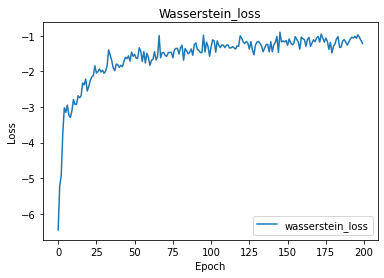

In [12]:
epoch = np.arange(1, 101)
fig, ax = plt.subplots()
loss = np.array(loss)
plt.plot(loss.T[0], label='wasserstein_loss')
#plt.plot(epoch, label='Epoch')
plt.title("Wasserstein_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

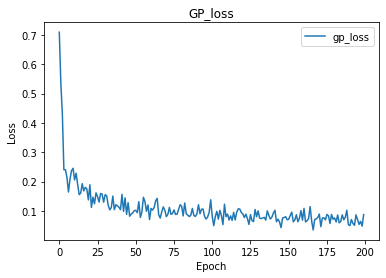

In [13]:
epoch = np.arange(1, 101)
fig, ax = plt.subplots()
loss = np.array(loss)
plt.plot(loss.T[1], label='gp_loss')
#plt.plot(epoch, label='Epoch')
plt.title("GP_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

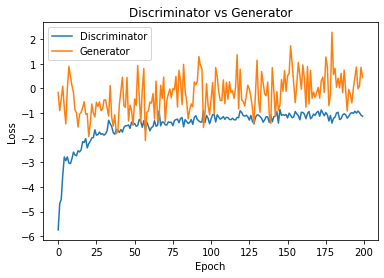

In [14]:
epoch = np.arange(1, 101)
fig, ax = plt.subplots()
loss = np.array(loss)
plt.plot(loss.T[2], label='Discriminator')
plt.plot(loss.T[3], label='Generator')
plt.title("Discriminator vs Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [15]:
# Plot 10 X 10
def generate_sample_plot(epoch, sample):
    fig, axes = plt.subplots(figsize=(12,12), nrows=10, ncols=10, sharey=True, sharex=True)
    for ax, image in zip(axes.flatten(), sample[epoch]):
        image = image
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(image.reshape((28,28)), cmap='Greys_r')

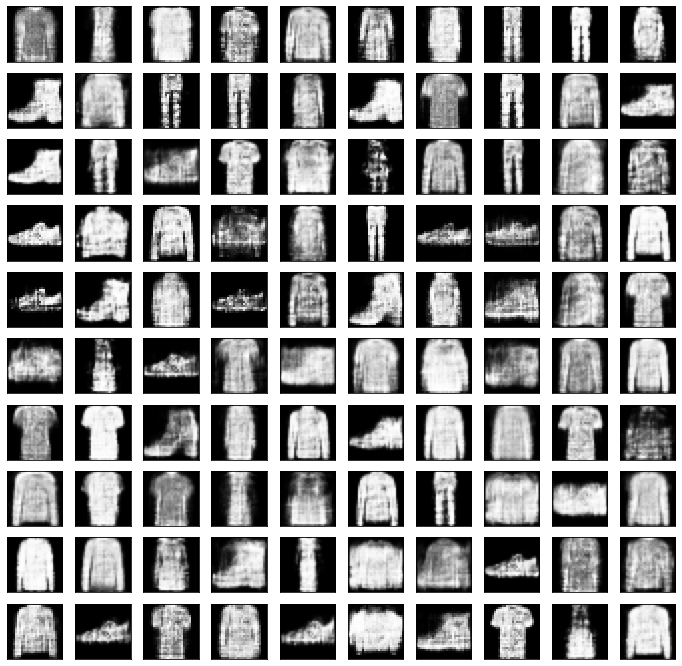

In [16]:
#Generate sample
z_size=100
sample=100
z = np.random.uniform(-1, 1, size=(sample, z_size))
z = torch.from_numpy(z).float().to(device)
G.eval() 
G = G.to(device)
generated_images = G(z)
generated_images_np = generated_images.detach().cpu().numpy()
generate_sample_plot(-1, [generated_images_np])